In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 128

# Create fast tokenizer

In [4]:
# First load the real tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-large")
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
# fast_tokenizer = SentencePieceBPETokenizer('vocab.txt')
# fast_tokenizer

('./sentencepiece.bpe.model',
 './special_tokens_map.json',
 './added_tokens.json')

# Load text data into memory


## Jigsaw

In [5]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')


In [6]:
train1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])
print(train.toxic.value_counts())
print(valid.toxic.value_counts())

0    352165
1    133610
Name: toxic, dtype: int64
0    6770
1    1230
Name: toxic, dtype: int64


## OLID

In [8]:
olid = pd.read_csv('/kaggle/input/olid2019/olid-training-v1.0.tsv', sep='\t')
olid = olid.rename(columns={"id": "id", "tweet": "comment_text", 'subtask_a': 'toxic'})
olid.toxic = (olid.toxic == 'OFF').astype(int)
# olid['comment_text'] = olid['comment_text'].str.replace('@USER', '')
olid.head()

,id,comment_text,toxic,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,1,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN


In [9]:
olid_test = pd.read_csv('/kaggle/input/olid2019/testset-levela.tsv', sep='\t')
olid_test_label = pd.read_csv('/kaggle/input/olid2019/labels-levela.csv', names = ['id', 'label'])

In [10]:
olid_test_label.label.value_counts()

NOT    620
OFF    240
Name: label, dtype: int64

In [11]:
olid_test = olid_test.set_index('id').join(olid_test_label.set_index('id'))

In [12]:
olid_test['toxic'] = (olid_test.label == 'OFF').astype(int).values

In [13]:
olid_test.head()

,tweet,label,toxic
id,,,
15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,1
27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,0
30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,0
13876,#Watching #Boomer getting the news that she is...,NOT,0
60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,1


In [14]:
from sklearn.model_selection import train_test_split
olid_train, olid_valid = train_test_split(olid, test_size=3240, random_state = 2020)
olid_train_1k = olid_train[0:1000]
olid_train_2k = olid_train[0:2000]
olid_train_5k = olid_train[0:5000]


## Encode them

In [15]:
def fast_encode_xlm(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.batch_encode_plus(text_chunk, pad_to_max_length = True, max_length = maxlen)
        all_ids.extend(np.array(encs.input_ids))
    
    return np.array(all_ids)

In [16]:
x_train = fast_encode_xlm(train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode_xlm(valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_test = fast_encode_xlm(test.content.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

In [17]:
# olid_encode = fast_encode_xlm(olid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_encode = fast_encode_xlm(olid_train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_1k_encode = fast_encode_xlm(olid_train_1k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_2k_encode = fast_encode_xlm(olid_train_2k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_5k_encode = fast_encode_xlm(olid_train_5k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_valid_encode = fast_encode_xlm(olid_valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_test_encode = fast_encode_xlm(olid_test.tweet.astype(str), tokenizer, maxlen = MAX_LEN)


In [18]:
y_olid_train = olid_train.toxic.values
y_olid_train_1k = olid_train_1k.toxic.values
y_olid_train_2k = olid_train_2k.toxic.values
y_olid_train_5k = olid_train_5k.toxic.values
y_olid_valid = olid_valid.toxic.values
y_olid_test = (olid_test_label.label == 'OFF').astype(int).values

# Build datasets objects

In [19]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [20]:
olid_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(olid_test_encode)
    .batch(BATCH_SIZE)
)
olid_valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_valid_encode, y_olid_valid))
    .batch(BATCH_SIZE)
)
olid_train_1k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_1k_encode, y_olid_train_1k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_2k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_2k_encode, y_olid_train_2k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_5k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_5k_encode, y_olid_train_5k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_encode, y_olid_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


# Load model into the TPU


In [21]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) #, options = run_opts)
    
    return model

In [22]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFAutoModelWithLMHead.from_pretrained('jplu/tf-xlm-roberta-large')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_roberta_for_masked_lm (TF ((None, 128, 250002),)    561192082 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 250002)]          0         
_________________________________________________________________
dense (Dense)                (None, 1)                 250003    
Total params: 561,442,085
Trainable params: 561,442,085
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 3s, sys: 45.5 s, total: 2min 48s
Wall time: 2min 51s


In [23]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Train Model

In [24]:
n_steps = x_train.shape[0] // BATCH_SIZE
model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3795/3795 [==============================] - 1705s 449ms/step - accuracy: 0.9645 - loss: 0.1283 - val_accuracy: 0.8465 - val_loss: 1.3301
Epoch 2/3
3795/3795 [==============================] - 1667s 439ms/step - accuracy: 0.9780 - loss: 0.0569 - val_accuracy: 0.8754 - val_loss: 0.3173
Epoch 3/3
3795/3795 [==============================] - 1670s 440ms/step - accuracy: 0.9804 - loss: 0.0509 - val_accuracy: 0.8656 - val_loss: 0.6812


In [25]:
n_steps = x_valid.shape[0] // BATCH_SIZE
model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Epoch 1/3
62/62 [==============================] - 27s 432ms/step - accuracy: 0.8629 - loss: 0.3444
Epoch 2/3
62/62 [==============================] - 27s 431ms/step - accuracy: 0.9092 - loss: 0.2088
Epoch 3/3
62/62 [==============================] - 27s 429ms/step - accuracy: 0.9308 - loss: 0.1807


# Submission

In [26]:
sub['toxic'] = model.predict(test_dataset, verbose=0)
sub.to_csv('submission.csv', index=False)

In [27]:
sub.describe()

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.137037
std,18421.082026,0.276311
min,0.000000,0.000000
25%,15952.750000,0.000013
50%,31905.500000,0.000876
75%,47858.250000,0.089468
max,63811.000000,0.997351


# Olid Zero-shot

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
olid_test.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test.to_csv('olid_test_0shot.csv', index=False)

roc_auc_score(y_true = olid_test.toxic, y_score = olid_test.toxic_predict)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


0.89096438172043

In [30]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss, f1_score
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(olid_test.toxic, olid_test.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test.toxic_predict]

the optimal threshold is 0.00931847095489502


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [31]:
f1_score(y_true = olid_test.toxic, y_pred = olid_test.toxic_predict_binary)


0.6942446043165468

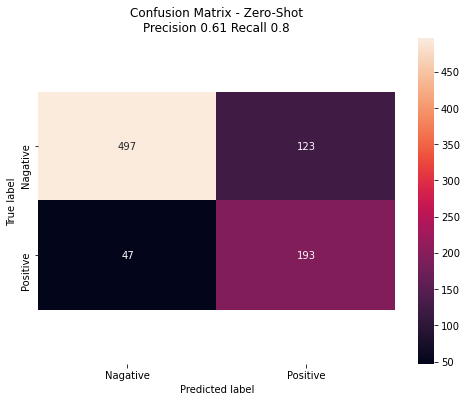

In [32]:
def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = matrix.ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Nagative', 'Positive'], 
                         columns = ['Nagative', 'Positive'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_matrix(olid_test.toxic, olid_test.toxic_predict_binary, name = 'Zero-Shot')


# Olid Few-shot

In [33]:
model.save_weights("/kaggle/working/ckpt.h5")
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[0.10043672],
       [0.00092617],
       [0.00168052],
       [0.00048089],
       [0.00079933]], dtype=float32)

In [34]:
with strategy.scope():
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
n_steps = olid_train_1k.shape[0] // BATCH_SIZE
model.fit(
    olid_train_1k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test1k = olid_test
olid_test1k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test1k.to_csv('olid_test_1k.csv', index=False)

print('1k roc is ' + str(roc_auc_score(y_true = olid_test1k.toxic, y_score = olid_test1k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test1k.toxic, olid_test1k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test1k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test1k.toxic_predict]

print('1k f1-score is ' + str(f1_score(y_true = olid_test1k.toxic, y_pred = olid_test1k.toxic_predict_binary)))


Epoch 1/10
7/7 [==============================] - 42s 6s/step - accuracy: 0.7813 - loss: 0.6678 - val_accuracy: 0.7914 - val_loss: 0.5579
Epoch 2/10
7/7 [==============================] - 5s 645ms/step - accuracy: 0.7718 - loss: 0.5488 - val_accuracy: 0.7781 - val_loss: 0.5607
Epoch 3/10
7/7 [==============================] - 11s 2s/step - accuracy: 0.7821 - loss: 0.5258 - val_accuracy: 0.7867 - val_loss: 0.5190
Epoch 4/10
7/7 [==============================] - 4s 633ms/step - accuracy: 0.7970 - loss: 0.4746 - val_accuracy: 0.7892 - val_loss: 0.5197
Epoch 5/10
7/7 [==============================] - 10s 1s/step - accuracy: 0.7970 - loss: 0.4825 - val_accuracy: 0.7895 - val_loss: 0.4900
Epoch 6/10
7/7 [==============================] - 10s 1s/step - accuracy: 0.7936 - loss: 0.4673 - val_accuracy: 0.7870 - val_loss: 0.4766
Epoch 7/10
7/7 [==============================] - 10s 1s/step - accuracy: 0.7890 - loss: 0.4719 - val_accuracy: 0.7895 - val_loss: 0.4730
Epoch 8/10
7/7 [==============

In [35]:
tf.tpu.experimental.initialize_tpu_system(tpu)
with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[0.10043672],
       [0.00092617],
       [0.00168052],
       [0.00048089],
       [0.00079933]], dtype=float32)

In [36]:
n_steps = olid_train_2k.shape[0] // BATCH_SIZE
model.fit(
    olid_train_2k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test2k = olid_test
olid_test2k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test2k.to_csv('olid_test_2k.csv', index=False)

print('2k roc is ' + str(roc_auc_score(y_true = olid_test2k.toxic, y_score = olid_test2k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test2k.toxic, olid_test2k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test2k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test2k.toxic_predict]

print('2k f1-score is ' + str(f1_score(y_true = olid_test2k.toxic, y_pred = olid_test2k.toxic_predict_binary)))


Epoch 1/10
15/15 [==============================] - 42s 3s/step - accuracy: 0.7875 - loss: 0.5758 - val_accuracy: 0.7778 - val_loss: 0.5585
Epoch 2/10
15/15 [==============================] - 11s 734ms/step - accuracy: 0.7970 - loss: 0.5011 - val_accuracy: 0.7880 - val_loss: 0.5104
Epoch 3/10
15/15 [==============================] - 11s 732ms/step - accuracy: 0.8024 - loss: 0.4683 - val_accuracy: 0.7898 - val_loss: 0.4772
Epoch 4/10
15/15 [==============================] - 11s 718ms/step - accuracy: 0.7949 - loss: 0.4652 - val_accuracy: 0.7904 - val_loss: 0.4688
Epoch 5/10
15/15 [==============================] - 11s 720ms/step - accuracy: 0.7922 - loss: 0.4548 - val_accuracy: 0.7904 - val_loss: 0.4675
Epoch 6/10
15/15 [==============================] - 11s 709ms/step - accuracy: 0.7965 - loss: 0.4526 - val_accuracy: 0.7901 - val_loss: 0.4628
Epoch 7/10
15/15 [==============================] - 11s 705ms/step - accuracy: 0.7986 - loss: 0.4472 - val_accuracy: 0.7914 - val_loss: 0.4619
Ep

In [37]:
tf.tpu.experimental.initialize_tpu_system(tpu)
with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[0.10043672],
       [0.00092617],
       [0.00168052],
       [0.00048089],
       [0.00079933]], dtype=float32)

In [38]:
n_steps = olid_train_5k.shape[0] // BATCH_SIZE 
model.fit(
    olid_train_5k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test5k = olid_test
olid_test5k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test5k.to_csv('olid_test_5k.csv', index=False)

print('5k roc is ' + str(roc_auc_score(y_true = olid_test5k.toxic, y_score = olid_test5k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test5k.toxic, olid_test5k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test5k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test5k.toxic_predict]

print('5k f1-score is ' + str(f1_score(y_true = olid_test5k.toxic, y_pred = olid_test5k.toxic_predict_binary)))

Epoch 1/10
39/39 [==============================] - 46s 1s/step - accuracy: 0.7981 - loss: 0.5207 - val_accuracy: 0.7886 - val_loss: 0.4867
Epoch 2/10
39/39 [==============================] - 14s 357ms/step - accuracy: 0.8019 - loss: 0.4477 - val_accuracy: 0.7907 - val_loss: 0.4683
Epoch 3/10
39/39 [==============================] - 14s 353ms/step - accuracy: 0.8007 - loss: 0.4463 - val_accuracy: 0.7904 - val_loss: 0.4620
Epoch 4/10
39/39 [==============================] - 14s 357ms/step - accuracy: 0.7956 - loss: 0.4435 - val_accuracy: 0.7910 - val_loss: 0.4585
Epoch 5/10
39/39 [==============================] - 14s 352ms/step - accuracy: 0.8034 - loss: 0.4408 - val_accuracy: 0.7901 - val_loss: 0.4557
Epoch 6/10
39/39 [==============================] - 9s 225ms/step - accuracy: 0.8009 - loss: 0.4419 - val_accuracy: 0.7901 - val_loss: 0.4560
Epoch 7/10
39/39 [==============================] - 14s 358ms/step - accuracy: 0.8046 - loss: 0.4359 - val_accuracy: 0.7895 - val_loss: 0.4553
Epo

In [39]:
tf.tpu.experimental.initialize_tpu_system(tpu)

with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[0.10043672],
       [0.00092617],
       [0.00168052],
       [0.00048089],
       [0.00079933]], dtype=float32)

In [40]:
n_steps = olid_train.shape[0] // BATCH_SIZE
model.fit(
    olid_train_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test10k = olid_test
olid_test10k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test10k.to_csv('olid_test_10k.csv', index=False)

print('10k roc is ' + str(roc_auc_score(y_true = olid_test10k.toxic, y_score = olid_test10k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test10k.toxic, olid_test10k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test10k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test10k.toxic_predict]

print('10k f1-score is ' + str(f1_score(y_true = olid_test10k.toxic, y_pred = olid_test10k.toxic_predict_binary)))


Epoch 1/10
78/78 [==============================] - 51s 652ms/step - accuracy: 0.7945 - loss: 0.4862 - val_accuracy: 0.7914 - val_loss: 0.4659
Epoch 2/10
78/78 [==============================] - 19s 249ms/step - accuracy: 0.7971 - loss: 0.4448 - val_accuracy: 0.7892 - val_loss: 0.4550
Epoch 3/10
78/78 [==============================] - 19s 247ms/step - accuracy: 0.8011 - loss: 0.4399 - val_accuracy: 0.7901 - val_loss: 0.4523
Epoch 4/10
78/78 [==============================] - 19s 246ms/step - accuracy: 0.8033 - loss: 0.4374 - val_accuracy: 0.7895 - val_loss: 0.4481
Epoch 5/10
78/78 [==============================] - 19s 250ms/step - accuracy: 0.8010 - loss: 0.4383 - val_accuracy: 0.7901 - val_loss: 0.4463
Epoch 6/10
78/78 [==============================] - 19s 249ms/step - accuracy: 0.8034 - loss: 0.4358 - val_accuracy: 0.7873 - val_loss: 0.4463
Epoch 7/10
78/78 [==============================] - 19s 247ms/step - accuracy: 0.8041 - loss: 0.4334 - val_accuracy: 0.7889 - val_loss: 0.4449